In [1]:
!pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
import anvil.server

anvil.server.connect("server_UVY6LDQRFPGICXIS4USQHERS-3ENXAGPOUODFMGJF")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
import pandas as pd
import re
import nltk
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from nltk.tokenize import word_tokenize


nltk.download('punkt')

# Loading data from train, test and valid datasets
train_df = pd.read_csv('/content/train.tsv', delimiter='\t', header=None)
test_df = pd.read_csv('/content/test.tsv', delimiter='\t', header=None)
val_df = pd.read_csv('/content/valid.tsv', delimiter='\t', header=None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
label_mapping = {'false': 0, 'half-true': 1, 'mostly-true': 1, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

TEXT+ALL META DATA

In [8]:
selected_columns = [2,3,4,5,6,7,8,9,10,11,12,13]

In [9]:



def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# tokenization func, from nltk libarray
def text_tokenization(text):
    return word_tokenize(text)


def merge_and_clean(dataframe, columns):
    merged_text = dataframe[columns].astype(str).agg(' '.join, axis=1)
    return merged_text.apply(preprocess_text)


selected_columns = [2,3,4,5,6,7,8,9,10,11,12,13]



train_texts = merge_and_clean(train_df, selected_columns).apply(text_tokenization)
test_texts = merge_and_clean(test_df, selected_columns).apply(text_tokenization)
val_texts = merge_and_clean(val_df, selected_columns).apply(text_tokenization)


total_tokens = [token for text in train_texts for token in text] + \
               [token for text in test_texts for token in text] + \
               [token for text in val_texts for token in text]
word_counts = Counter(total_tokens)
vocab_length = len(word_counts)

# Mapping unique words to tokens
word_indices = {word: idx + 1 for idx, word in enumerate(word_counts)}


def convert_tokens_to_indices(token_lists):
    return [[word_indices.get(token, 0) for token in tokens] for tokens in token_lists],True

train_idx,status1 = convert_tokens_to_indices(train_texts)
if status1:
    word_s1=True
test_idx,status2 = convert_tokens_to_indices(test_texts)
if status2:
    word_s2=True
val_idx,status3 = convert_tokens_to_indices(val_texts)
if status3:
    word_s3=True

# padding
def sequence_padding(sequences, max_length):
    sequence_padded = pad_sequence([torch.tensor(sequence) for sequence in sequences],
                                   batch_first=True, padding_value=0)
    return True,sequence_padded[:, :max_length]
def find_max_sequence_length(sequences):
    try:
        max_length = max(len(sequence) for sequence in sequences)
        return True, max_length
    except Exception as e:
        print(f"Error in find_max_sequence_length: {e}")
        return False, 0

max_length = max(len(s) for seq in [train_idx, test_idx, val_idx] for s in seq)


train_cond,X_train_padded = sequence_padding(train_idx, max_length)
if train_cond!=True:
    print("Exception")
test_cond,X_test_padded = sequence_padding(test_idx, max_length)
if test_cond!=True:
    print("Exception")
val_cond,X_val_padded = sequence_padding(val_idx, max_length)
if val_cond!=True:
    print("Exception")

# label to tensors

def map_labels_to_tensors(dataframe, column_index, label_mapping):

    try:
        mapped_labels = dataframe[column_index].map(label_mapping)
        return torch.tensor(mapped_labels.values, dtype=torch.float)
    except Exception as e:
        print(f"Error during label mapping and tensor conversion: {e}")
        return None


y_train = map_labels_to_tensors(train_df, 1, label_mapping)
y_test = map_labels_to_tensors(test_df, 1, label_mapping)
y_val = map_labels_to_tensors(val_df, 1, label_mapping)


if y_train is not None and y_test is not None and y_val is not None:
    print("Labels successfully mapped to tensors.")
else:
    print("An error occurred during label mapping.")


assert X_train_padded.size(0) == y_train.size(0), "Inconsistent data lengths for training set"


batch_size = 32


train_dataset = TensorDataset(X_train_padded, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_padded, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_padded, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Labels successfully mapped to tensors.


In [10]:
word_to_index=word_indices

In [11]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Train Func
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        inputs, labels = batch


        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim)) for fs in filter_sizes])

        self.lstm = nn.LSTM(n_filters * len(filter_sizes), lstm_hidden_dim, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(2 * lstm_hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))

        lstm_output, (hidden, cell) = self.lstm(cat.unsqueeze(1))
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        return self.fc(hidden)


In [13]:
# hyperparameters

vocab_size = len(word_to_index) + 1
embedding_dim = 100
n_filters = 100
filter_sizes = [2, 3, 4]
lstm_hidden_dim = 256
output_dim = 1
dropout = 0.3


model = CNNBiLSTMModel(vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout)
model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.BCEWithLogitsLoss()

In [14]:

train_loss_1, train_acc_1 = [], []
val_loss_1, val_acc_1 = [], []


num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_loss_1.append(train_loss)
    val_loss_1.append(val_loss)
    train_acc_1.append(train_acc)
    val_acc_1.append(val_acc)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}')

    #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%')


Epoch: 1, Train Loss: 0.713, Train Acc: 0.53, Val Loss: 0.700, Val Acc: 0.48
Epoch: 2, Train Loss: 0.711, Train Acc: 0.53, Val Loss: 0.706, Val Acc: 0.52
Epoch: 3, Train Loss: 0.707, Train Acc: 0.53, Val Loss: 0.759, Val Acc: 0.52
Epoch: 4, Train Loss: 0.707, Train Acc: 0.53, Val Loss: 0.735, Val Acc: 0.52
Epoch: 5, Train Loss: 0.703, Train Acc: 0.53, Val Loss: 0.705, Val Acc: 0.52


In [15]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.688, Test Acc: 56.16%


In [16]:
dropout = 0.5
train_loss_2, train_acc_2 = [], []
val_loss_2, val_acc_2 = [], []
model = CNNBiLSTMModel(vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout)
model=model.to(device)
# Loss ,Optimizer we used
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)


In [17]:
# dropout = 0.5
# train_loss_2, train_acc_2 = [], []
# val_loss_2, val_acc_2 = [], []
# model = CNNBiLSTMModel(vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout)
# model=model.to(device)
# # Loss and Optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters())


In [18]:




num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_loss_2.append(train_loss)
    val_loss_2.append(val_loss)
    train_acc_2.append(train_acc)
    val_acc_2.append(val_acc)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}')

    #print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%')


Epoch: 1, Train Loss: 0.677, Train Acc: 0.58, Val Loss: 0.668, Val Acc: 0.58
Epoch: 2, Train Loss: 0.640, Train Acc: 0.63, Val Loss: 0.649, Val Acc: 0.61
Epoch: 3, Train Loss: 0.604, Train Acc: 0.67, Val Loss: 0.675, Val Acc: 0.59
Epoch: 4, Train Loss: 0.575, Train Acc: 0.69, Val Loss: 0.666, Val Acc: 0.59
Epoch: 5, Train Loss: 0.543, Train Acc: 0.72, Val Loss: 0.671, Val Acc: 0.58


In [19]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.675, Test Acc: 59.65%


CHECKING THE PERFORMANCE OF SET 1(BEFORE TUNING) & SET(AFTER TUNING)

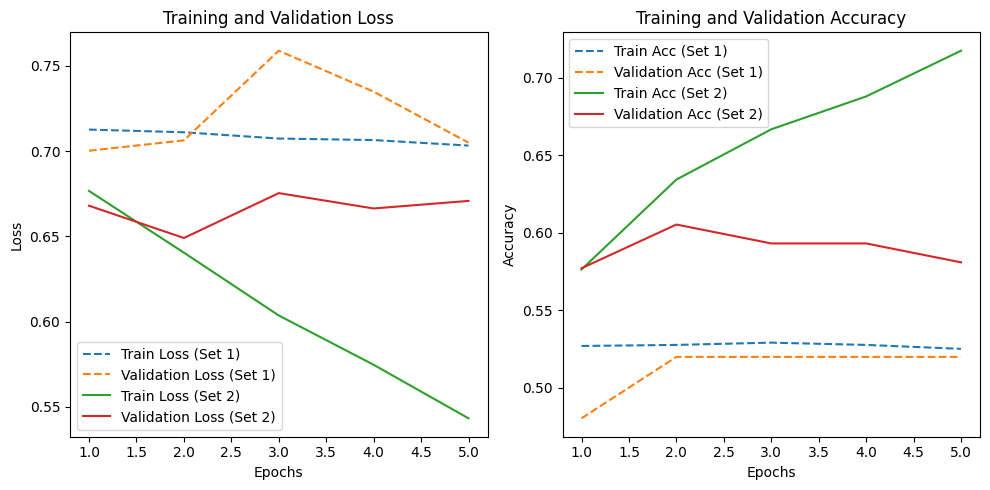

In [20]:
import matplotlib.pyplot as plt

# Data for Set 1
epochs_1 = [1, 2, 3, 4, 5]


# Data for Set 2 (After Tuning)
epochs_2 = [1, 2, 3, 4, 5]


plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_1, train_loss_1, label='Train Loss (Set 1)', linestyle='dashed')
plt.plot(epochs_1, val_loss_1, label='Validation Loss (Set 1)', linestyle='dashed')
plt.plot(epochs_2, train_loss_2, label='Train Loss (Set 2)', linestyle='solid')
plt.plot(epochs_2, val_loss_2, label='Validation Loss (Set 2)', linestyle='solid')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_1, train_acc_1, label='Train Acc (Set 1)', linestyle='dashed')
plt.plot(epochs_1, val_acc_1, label='Validation Acc (Set 1)', linestyle='dashed')
plt.plot(epochs_2, train_acc_2, label='Train Acc (Set 2)', linestyle='solid')
plt.plot(epochs_2, val_acc_2, label='Validation Acc (Set 2)', linestyle='solid')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


TEXT + OUR META DATA

In [21]:
selected_columns = [2,3,5,7,13]

In [22]:



def preprocess_text(text):
    text = re.sub(r'[^\w\s]', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# tokenization func, from nltk libarray
def text_tokenization(text):
    return word_tokenize(text)


def merge_and_clean(dataframe, columns):
    merged_text = dataframe[columns].astype(str).agg(' '.join, axis=1)
    return merged_text.apply(preprocess_text)


selected_columns = [2,3,5,7,13]



train_texts = merge_and_clean(train_df, selected_columns).apply(text_tokenization)
test_texts = merge_and_clean(test_df, selected_columns).apply(text_tokenization)
val_texts = merge_and_clean(val_df, selected_columns).apply(text_tokenization)


total_tokens = [token for text in train_texts for token in text] + \
               [token for text in test_texts for token in text] + \
               [token for text in val_texts for token in text]
word_counts = Counter(total_tokens)
vocab_length = len(word_counts)

# Mapping unique words to tokens
word_indices = {word: idx + 1 for idx, word in enumerate(word_counts)}


def convert_tokens_to_indices(token_lists):
    return [[word_indices.get(token, 0) for token in tokens] for tokens in token_lists],True

train_idx,status1 = convert_tokens_to_indices(train_texts)
if status1:
    word_s1=True
test_idx,status2 = convert_tokens_to_indices(test_texts)
if status2:
    word_s2=True
val_idx,status3 = convert_tokens_to_indices(val_texts)
if status3:
    word_s3=True

# padding
def sequence_padding(sequences, max_length):
    sequence_padded = pad_sequence([torch.tensor(sequence) for sequence in sequences],
                                   batch_first=True, padding_value=0)
    return True,sequence_padded[:, :max_length]
def find_max_sequence_length(sequences):
    """Find the maximum sequence length in a list of sequences."""
    try:
        max_length = max(len(sequence) for sequence in sequences)
        return True, max_length
    except Exception as e:
        print(f"Error in find_max_sequence_length: {e}")
        return False, 0

max_length = max(len(s) for seq in [train_idx, test_idx, val_idx] for s in seq)


train_cond,X_train_padded = sequence_padding(train_idx, max_length)
if train_cond!=True:
    print("Exception")
test_cond,X_test_padded = sequence_padding(test_idx, max_length)
if test_cond!=True:
    print("Exception")
val_cond,X_val_padded = sequence_padding(val_idx, max_length)
if val_cond!=True:
    print("Exception")

# labels to tensors

def map_labels_to_tensors(dataframe, column_index, label_mapping):

    try:
        mapped_labels = dataframe[column_index].map(label_mapping)
        return torch.tensor(mapped_labels.values, dtype=torch.float)
    except Exception as e:
        print(f"Error during label mapping and tensor conversion: {e}")
        return None


y_train = map_labels_to_tensors(train_df, 1, label_mapping)
y_test = map_labels_to_tensors(test_df, 1, label_mapping)
y_val = map_labels_to_tensors(val_df, 1, label_mapping)


if y_train is not None and y_test is not None and y_val is not None:
    print("Labels successfully mapped to tensors.")
else:
    print("An error occurred during label mapping.")


assert X_train_padded.size(0) == y_train.size(0), "Inconsistent data lengths for training set"


batch_size = 32


train_dataset = TensorDataset(X_train_padded, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_padded, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test_padded, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Labels successfully mapped to tensors.


In [23]:
dropout = 0.5


model = CNNBiLSTMModel(vocab_size, embedding_dim, n_filters, filter_sizes, lstm_hidden_dim, output_dim, dropout)
model = model.to(device)



In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dropout = 0.5
criterion = nn.BCEWithLogitsLoss()

In [25]:


num_epochs = 5
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}')




Epoch: 1, Train Loss: 0.681, Train Acc: 0.57, Val Loss: 0.676, Val Acc: 0.57
Epoch: 2, Train Loss: 0.662, Train Acc: 0.61, Val Loss: 0.649, Val Acc: 0.63
Epoch: 3, Train Loss: 0.638, Train Acc: 0.64, Val Loss: 0.664, Val Acc: 0.59
Epoch: 4, Train Loss: 0.617, Train Acc: 0.66, Val Loss: 0.644, Val Acc: 0.61
Epoch: 5, Train Loss: 0.579, Train Acc: 0.70, Val Loss: 0.644, Val Acc: 0.62


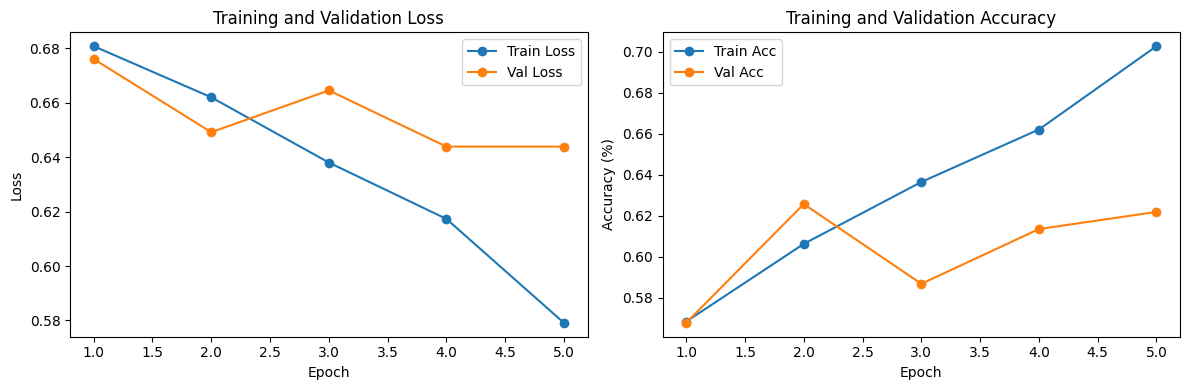

In [26]:
import matplotlib.pyplot as plt
import numpy as np


epochs = np.arange(1, len(train_loss_list) + 1)


plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, val_loss_list, label='Val Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Acc', marker='o', linestyle='-')
plt.plot(epochs, val_acc_list, label='Val Acc', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [27]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')


Test Loss: 0.643, Test Acc: 64.54%


# **Web Link Server Callable**

In [28]:
@anvil.server.callable
def predict_fake_best(label,statement,subject,job,party,location):
  arguments_list = [label, statement, subject,job, party,location]


  arguments_list = pd.DataFrame([arguments_list])

  print(arguments_list)

  def clean_text(text):
      text = re.sub(r'\W', ' ', str(text))
      text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
      text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
      text = re.sub(r'\s+', ' ', text, flags=re.I)
      return text


  def tokenize(text):
      return word_tokenize(text.lower())
  def concatenate_and_clean_server(row):
      concatenated_text = ' '.join(str(row[col]) for col in range(1,6))
      return clean_text(concatenated_text)


  def tokens_to_indexes(tokens_list):
      return [[word_to_index.get(token, 0) for token in tokens] for tokens in tokens_list]



  predict_statement = arguments_list.apply(concatenate_and_clean_server, axis=1).apply(tokenize)

  print(predict_statement)



  all_tokens = [token for statement in predict_statement for token in statement]
  vocab = Counter(all_tokens)
  vocab_size = len(vocab)


  word_to_index = {word: index + 1 for index, word in enumerate(vocab)}


  predict_sequences = tokens_to_indexes(predict_statement)


  # Padding
  def pad_sequences(sequences, maxlen):
      padded_sequences = pad_sequence([torch.tensor(seq) for seq in sequences],
                                      batch_first=True, padding_value=0)
      print("padded:",padded_sequences[:, :maxlen])
      return padded_sequences[:, :maxlen]

  max_seq_length = max(max(len(seq) for seq in sequences) for sequences in [predict_sequences])
  print("max:",max_seq_length)
  X_predict = pad_sequences(predict_sequences, max_seq_length)
  print("X:",X_predict.size())


  label_mapping = {'false': 0, 'half-true': 1, 'mostly-true': 1, 'true': 1, 'barely-true': 0, 'pants-fire': 0}
  y_predict = torch.tensor(arguments_list[0].map(label_mapping).values, dtype=torch.float)


  print(y_predict.size())



  assert X_predict.size(0) == y_predict.size(0), "Mismatch in number of samples between X_train and y_train"


  batch_size = 4

  pred_data = TensorDataset(X_predict, y_predict)
  #pred_data = TensorDataset(X_predict)
  pred_loader = DataLoader(pred_data, batch_size=batch_size)


  pred_loss, pred_acc = evaluate(model, pred_loader, criterion)
  print("predicted outcome",pred_acc)


  return pred_acc

In [29]:
###########################################################################################################################################################################################3####3

In [30]:
###########################################################################################################################################################################################3####3

In [31]:
###########################################################################################################################################################################################3####3

In [32]:
###########################################################################################################################################################################################3####3